# Phindr3D in python

This notebook acts as a basic GUI/framework for Phindr3D to work in python.

In [1]:
%matplotlib widget
import phindr_functions as phi
# import phindr_organoidCSApp as org
# import phindr_clustering as clu
import numpy as np

# import matplotlib.pyplot as plt
# import pandas as pd

# Preliminary set-up:

In [2]:
param = phi.initParameters()

#change parameters as needed
#SV sizes
param.tileX = 10
param.tileY = 10
param.tileZ = 3
#MV sizes
param.megaVoxelTileX = 5
param.megaVoxelTileY = 5
param.megaVoxelTileZ = 2
#Binning
param.numVoxelBins = 20
param.numSuperVoxelBins = 15
param.numMegaVoxelBins = 40
#foreground fraction thresholds
param.intensityThresholdTuningFactor = 0.5
param.superVoxelThresholdTuningFactor = 0.5
param.megaVoxelThresholdTuningFactor = 0.5
#training parameters:
param.randTrainingSuperVoxel = 10000
param.pixelsPerImage = 200 
param.randTrainingFields = 5
param.randTrainingPerTreatment = 1
param.showBincenters = True

param.intensityNormPerTreatment = False

#misc. (generally don't need to touch)
param.minQuantileScaling = .5
param.maxQuantileScaling = .5
param.countBackground = False
param.showImage = 0
param.startZPlane = 1
param.endZPlane = 500
param.numRemoveZStart = 1
param.numRemoveZEnd = 1
param.computeTAS = 0
param.trainingPerColumn = False
param.treatmentColNameForNormalization = ''
param.imageTreatments = []
param.allTreatments = []
param.trainingColforImageCategories = []
param.superVoxelPerField = param.randTrainingSuperVoxel//param.randTrainingFields
param.lowerbound = [0, 0, 0]
param.upperbound = [1, 1, 1]
param.numChannels = 3 

#don't need to touch these 
param.svcolormap = phi.random_cmap(map_len=param.numSuperVoxelBins+1)
param.mvcolormap = phi.random_cmap(map_len=param.numMegaVoxelBins+1)


# File loading:
Load folder containing images of interest

NOTE:
-  image names must follow strucuture: (image identification code) + p(z stack number) + ch(channelnumber) + (whatever) + .tiff 
- images in folder also need to have consistent dimensions (constant number of z slices; constant number of channels)

In [3]:
folder_path = r'E:\Phindr3D_screenC\screenC\plate1' #r'D:\20210326 - iN_BH3Mimetic_Phindr3D\20210326 - iN_BH3-mimetic_Phindr3D__2021-03-26T07_48_34-Measurement 1\Images' #r'path_to_images'

files, imageIDs, treatmentids, idstreatment = phi.get_files(folder_path, ID_pos='start', ID_mark=None, treat_mark='T', treat_endmark='_', ID_markextra='OB', slice_mark='Z', chan_mark='CH')
allImageID = imageIDs
#will be empty list if treat_mark is none.
param.imageTreatments = idstreatment
param.treatmentColNameForNormalization = treatmentids
if len(idstreatment) > 0:
    param.allTreatments = np.array(list(treatmentids.keys()), dtype='object')

#change This parameter below to True to get scaling factors separately for each treatment.
param.intensityNormPerTreatment = True

print('number of images:', len(imageIDs))
print('Treatments found:')
print(param.allTreatments)
#properly calculate number of channels
#slices in first ID:
tmpslices = list(files[imageIDs[0]].keys())
param.numChannels = len(files[imageIDs[0]][tmpslices[0]])

number of images: 355
Treatments found:
['TEV' 'TMYC' 'TMYC-T58A' 'TBcl-2' 'TBcl-XL' 'TSNAIL' 'Tp53-R248W'
 'Tp53-R273H' 'TPI3K' 'TPar']


# Rescale intensities:

want to rescale to between 1 and 0

In [4]:

param = phi.getScalingFactorforImages(files, allImageID, param)

print('Lowerbounds:', param.lowerbound)
print('Upperbounds:', param.upperbound)


Lowerbounds: [[ 575.   1567.    363.  ]
 [ 510.    803.91  271.  ]
 [ 479.   1003.    357.  ]
 [ 302.   1055.    261.  ]
 [ 827.   1730.    354.  ]
 [ 356.    996.    259.  ]
 [ 263.    950.    234.  ]
 [ 798.    836.    227.  ]
 [ 394.   1845.    331.34]
 [ 530.    864.    237.  ]]
Upperbounds: [[ 5749.05 14198.15  3230.  ]
 [ 2645.    8259.09 13017.27]
 [ 2088.    7374.   26863.22]
 [ 2825.71  8287.61  3489.61]
 [ 9303.   19339.94  2229.  ]
 [ 1937.   16568.44 20560.  ]
 [ 1411.   15211.07  6783.01]
 [ 3737.37 36034.88  8560.  ]
 [ 2110.   63669.66  5024.66]
 [ 3289.57 37580.41  3998.  ]]


# Threshold images:
get threshold value to use from training data


In [5]:
param = phi.getImageThresholdValues(files, allImageID, param)
intensityThreshold = np.quantile(param.intensityThresholdValues, param.intensityThresholdTuningFactor, axis=0)
param.intensityThreshold = np.reshape(intensityThreshold, (1, param.numChannels))

print(param.intensityThreshold)

[[0.28562245 0.28710938 0.27255625]]


# Cluster pixels:
compute pixel categories 

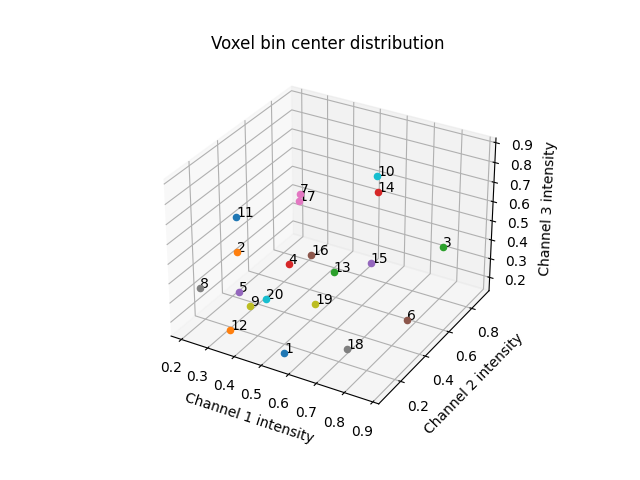

[[0.55573211 0.08760358 0.17852053]
 [0.29250009 0.27162399 0.47901496]
 [0.80340289 0.81378477 0.39554474]
 [0.3955204  0.44756543 0.35665334]
 [0.23789727 0.37432822 0.18221868]
 [0.87215684 0.35303092 0.32425639]
 [0.53554313 0.25486728 0.87252564]
 [0.20861018 0.15189692 0.32607174]
 [0.34812091 0.25009367 0.23176511]
 [0.51869365 0.89784021 0.61077495]
 [0.34502864 0.17369178 0.7305269 ]
 [0.35047669 0.09897095 0.19848077]
 [0.65338015 0.25944623 0.53066926]
 [0.66824289 0.56567159 0.76603795]
 [0.64316712 0.57128187 0.38864075]
 [0.36439759 0.68763541 0.24753079]
 [0.43867373 0.44203908 0.69969923]
 [0.75228138 0.14854388 0.25054964]
 [0.55040796 0.33504691 0.27601586]
 [0.47069465 0.12583231 0.39852942]]
(20, 3)


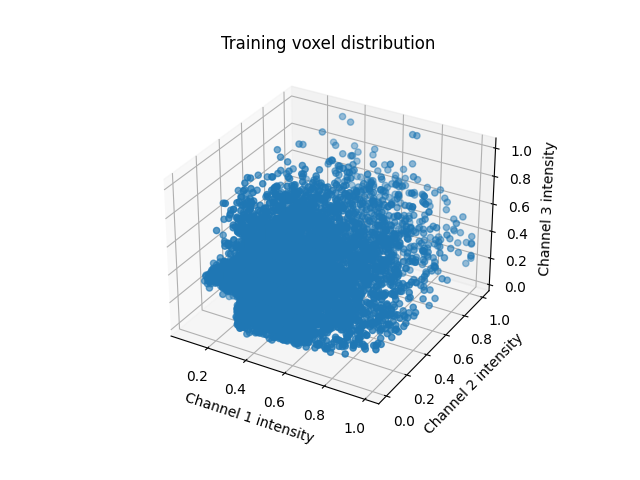

In [6]:
param = phi.getPixelBinCenters(files, allImageID, param)
print(param.pixelBinCenters) #20 different pixel categories made up of scaled intensities of different channels
print(param.pixelBinCenters.shape)

# Define super voxels:
use pixel categories to make some supervoxels! (also cluster super voxels into bins/categories)

c:\Users\teole\anaconda3\envs\phy479\phindr_functions.py:1481: RuntimeWarning: invalid value encountered in true_divide
  superVoxelProfile = np.divide(superVoxelProfile, np.array([np.sum(superVoxelProfile, axis=1)]).T) #dont worry about divide by zero errors, they are supposed to happen here!


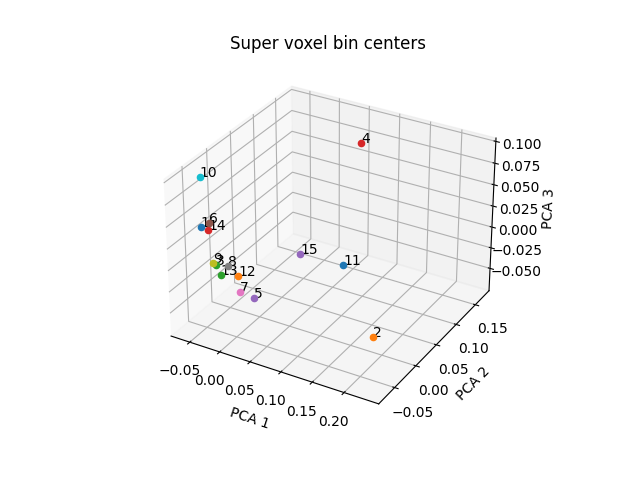

[[1.45195713e-04 4.12758162e-01 8.79964098e-04 1.29832667e-01
  3.91567537e-02 1.35281385e-04 4.34746646e-03 1.26574019e-01
  5.79942274e-02 8.39977921e-03 5.17594581e-02 4.34959892e-03
  1.17375860e-02 3.56474081e-03 1.56061625e-02 2.44564618e-02
  6.31890488e-02 4.87012987e-05 1.44124119e-02 3.06523138e-02]
 [4.84366620e-02 6.93889390e-17 3.46944695e-18 3.85550141e-05
  1.51224922e-05 1.87230856e-05 3.12250226e-17 1.01029955e-02
  1.59851918e-02 2.77555756e-17 1.93426439e-04 9.07668445e-01
  8.68254601e-05 1.38777878e-17 7.63278329e-17 6.93889390e-17
  3.46944695e-17 2.92000605e-04 2.08128691e-03 1.50807658e-02]
 [3.02207504e-03 1.38935025e-02 2.19874868e-01 6.14459778e-02
  2.62909695e-02 4.47067379e-02 1.60275307e-02 3.40346229e-03
  5.36807835e-02 2.45671964e-02 1.01015893e-02 1.09042535e-02
  4.79238894e-02 5.70832167e-02 2.36332648e-01 3.04414085e-02
  3.67409229e-02 3.78088812e-03 9.03246151e-02 9.45346479e-03]
 [6.97466379e-01 3.87096774e-05 3.46944695e-18 3.44086022e-05
  1.2

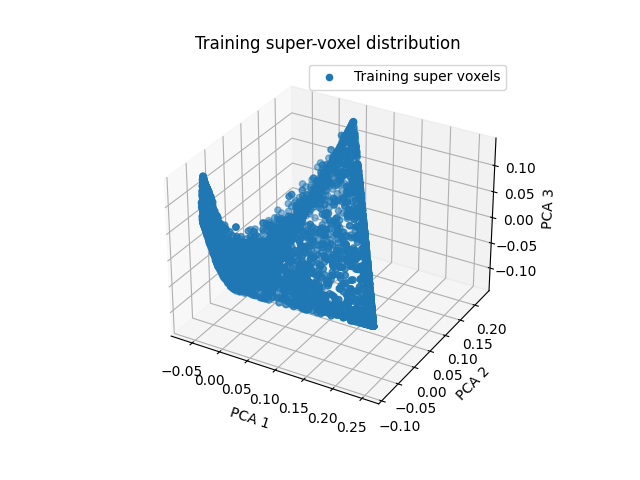

In [7]:
# param.showImage = True
param = phi.getSuperVoxelBinCenters(files, allImageID, param)
print(param.supervoxelBincenters) #15 different supervoxel categories made up of frequencies of 20 different pixel categories
print(param.supervoxelBincenters.shape)

#analyze bin centers
#from scipy.spatial.distance 


# Combine super voxels to mega voxels:
use super voxel categories and tileprofile to get megavoxels. also get megavoxel bins/categories

c:\Users\teole\anaconda3\envs\phy479\phindr_functions.py:1481: RuntimeWarning: invalid value encountered in true_divide
  superVoxelProfile = np.divide(superVoxelProfile, np.array([np.sum(superVoxelProfile, axis=1)]).T) #dont worry about divide by zero errors, they are supposed to happen here!
c:\Users\teole\anaconda3\envs\phy479\phindr_functions.py:955: RuntimeWarning: invalid value encountered in true_divide
  megaVoxelProfile = np.divide(megaVoxelProfile, np.array([np.sum(megaVoxelProfile, axis=1)]).T) #hopefully this works, they ask for elementwise, but the arrays seem to have different shapes.


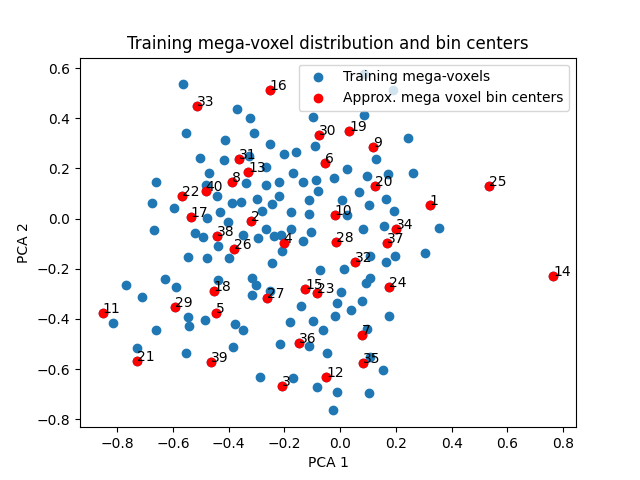

[[2.46869410e-01 3.10077519e-02 1.38777878e-17 1.38777878e-17
  1.55038760e-02 2.72212284e-01 0.00000000e+00 5.47604850e-02
  1.55038760e-02 2.62870205e-01 1.38777878e-17 1.28205128e-02
  0.00000000e+00 8.84516001e-02 0.00000000e+00]
 [1.08543417e-02 0.00000000e+00 1.31530250e-01 4.58221345e-02
  1.47736682e-01 5.95238095e-03 1.03252131e-01 2.16670709e-02
  1.17831974e-01 3.31710687e-02 2.89635623e-02 9.11646301e-02
  1.94726264e-01 2.46900580e-02 4.26374529e-02]
 [0.00000000e+00 4.94820181e-01 0.00000000e+00 2.70386131e-01
  1.83760684e-02 5.55555556e-03 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 1.91284794e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00 1.95772696e-02]
 [2.67670486e-02 8.51063830e-03 1.38810693e-01 2.96388434e-02
  1.86238953e-01 0.00000000e+00 1.26088380e-01 3.04048009e-02
  2.07659574e-02 0.00000000e+00 5.60436443e-02 2.44536825e-01
  3.01494817e-02 7.24058920e-02 2.96388434e-02]
 [6.93889390e-18 9.90806878e-02 1.29870130e-02 2.47640693e-01
  

In [8]:
param = phi.getMegaVoxelBinCenters(files, allImageID, param)
print(param.megaVoxelBincenters)
print(param.megaVoxelBincenters.shape)

# Profile images:


In [9]:
# to use previously calculated categories, uncomment lines below to specify different location of files 
# to be analyzed: EDIT HERE
# folder_path =  r'E:\Phindr3D_screenC\screenC\plate2' 

###
# files, imageIDs, treatmentids, idstreatment = phi.get_files(folder_path, ID_pos='start', ID_mark=None, treat_mark='T', treat_endmark='_', ID_markextra='OB', slice_mark='Z', chan_mark='CH')
# param.imageTreatments = idstreatment
# param.treatmentColNameForNormalization = treatmentids
# if len(idstreatment) > 0:
#     param.allTreatments = np.array(list(treatmentids.keys()), dtype='object')
# tmpslices = list(files[imageIDs[0]].keys())
# param.numChannels = len(files[imageIDs[0]][tmpslices[0]])
# allImageID = imageIDs
###

#Set to True to show images in process (will show LARGE number of images): EDIT HERE
param.showImage = False

#customize output file and location: EDIT HERE
outputFolder = r''
outputFileName ='organoidsplate2.csv'

param, resultIM, resultRaw, df = phi.extractImageLevelTextureFeatures(files, allImageID, param, outputFileName=outputFileName, outputDir=outputFolder)

from IPython.display import display
display(df)

c:\Users\teole\anaconda3\envs\phy479\phindr_functions.py:1481: RuntimeWarning: invalid value encountered in true_divide
  superVoxelProfile = np.divide(superVoxelProfile, np.array([np.sum(superVoxelProfile, axis=1)]).T) #dont worry about divide by zero errors, they are supposed to happen here!
c:\Users\teole\anaconda3\envs\phy479\phindr_functions.py:955: RuntimeWarning: invalid value encountered in true_divide
  megaVoxelProfile = np.divide(megaVoxelProfile, np.array([np.sum(megaVoxelProfile, axis=1)]).T) #hopefully this works, they ask for elementwise, but the arrays seem to have different shapes.
c:\Users\teole\anaconda3\envs\phy479\phindr_functions.py:655: RuntimeWarning: invalid value encountered in true_divide
  imageProfile = imageProfile / np.sum(imageProfile) #normalize the image profile



All done.


,ImageID,treatment,numMV,MV1,MV2,MV3,MV4,MV5,MV6,MV7,...,MV31,MV32,MV33,MV34,MV35,MV36,MV37,MV38,MV39,MV40
0,P1__Wr02c02__F1__OB1,TEV,8.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
1,P1__Wr02c02__F2__OB1,TEV,30.0,0.0,0.000000,0.000000,0.266667,0.0,0.033333,0.0,...,0.000000,0.000000,0.033333,0.0,0.000000,0.033333,0.000000,0.000000,0.0,0.300000
2,P1__Wr02c02__F2__OB2,TEV,39.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.897436,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.025641,0.0,0.000000
3,P1__Wr02c02__F3__OB6,TEV,36.0,0.0,0.000000,0.111111,0.027778,0.0,0.055556,0.0,...,0.166667,0.111111,0.055556,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.166667
4,P1__Wr02c02__F3__OB4,TEV,27.0,0.0,0.000000,0.037037,0.037037,0.0,0.037037,0.0,...,0.222222,0.000000,0.259259,0.0,0.000000,0.000000,0.037037,0.074074,0.0,0.074074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350,P1__Wr07c11__F6__OB1,TPar,8.0,0.0,0.000000,0.000000,0.000000,0.5,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
351,P1__Wr07c11__F6__OB2,TPar,8.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.250000,0.0,0.000000
352,P1__Wr07c11__F7__OB1,TPar,8.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.125000,0.000000,0.0,0.000000,0.000000,0.000000,0.125000,0.0,0.000000
353,P1__Wr07c11__F8__OB1,TPar,7.0,0.0,0.571429,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000


In [10]:
import pickle
with open('paramfile.pkl', 'wb') as f:
    pickle.dump(param, f, pickle.HIGHEST_PROTOCOL)


# Cluster images:

# Classify images: